# Model Order Reduction & Machine Learning - Project
## Nonlinear Elliptic problem (NEP) **POD and POD-NN**

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# Run to avoid to many warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [5]:
np.random.seed(23)

# PART 1 - Problem definition
Let us consider the two-dimensional spatial domain $\Omega = (0, 1)^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2$, find $u(\mu)$ such that
$$
-\Delta u(\mu) + \frac{\mu_0}{\mu_1} (e^{\mu_1 u(\mu)} - 1) = g(x;\mu) \text{  (NEP1)}
$$
with homogeneous Dirichlet condition on the boundary, i.e. zero-boundary condition.

The forcing term, that does not depend on the parameters, defined as
$$
g(x;\mu) = g_1 = 100 \sin(2\pi x_0) \cos(2\pi x_1) \quad \forall x = (x_0, x_1) \in \Omega.
$$

**Tasks:**

1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model -> using high fidelity element approximation of POD
2. Solve the problem with a parametric PINN -> find the NN structure to reduce the problem
3. Compare the two approaches in terms of computational costs and accuracy with respect to the full order model -> compare in terms of execution time & error
4. **Optional:** Solve the problem with the POD-NN approach and compare it to the other two strategies.

## 1. High fidelity solution of NEP1
#### Problem terms definition

In [6]:
# Points on which we want to integrate - We leave the structure of Lab12

# Points for the diffusion term
def Elliptic_a(numPoints, points): 
	values_a = np.ones(numPoints, order='F') # Fortran order of memorization of the matrix: column by column
	return values_a.ctypes.data

# Points for the reaction term
def Elliptic_c(numPoints, points):
	values_c = np.ones(numPoints, order='F') 
	return values_c.ctypes.data    

In [7]:
def Elliptic_non_linear_c(numPoints, points, u, u_x, u_y):
	vec_u = gedim.make_nd_array(u, numPoints, np.double) # Evaluation of the function in the quadrature points numPoints
	values_nl_c = vec_u
	return values_nl_c.ctypes.data

In [8]:
def Elliptic_non_linear_der_f(numPoints, points, u, u_x, u_y):
    # Converts u_x and u_y pointers or arrays to NumPy arrays
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
	values_nl_d_f = np.zeros((2, numPoints), order='F')

    # Inserts the partial derivatives of u into the new array values_nl_d_f
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
    
	return values_nl_d_f.ctypes.data

In [9]:
# Nonlinear reaction term: DEPENDS ON MU
def Elliptic_non_linear_f(numPoints, points, u, u_x, u_y): 
    vec_u = gedim.make_nd_array(u, numPoints, np.double)
    vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
    vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
    
    values_nl_f = (mu_0/mu_1) * (np.exp(mu_1*vec_u)-1) # Computation of f
    
    return values_nl_f.ctypes.data

In [10]:
def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

In [11]:
# Definition of the forcing term g_2 --> leave it called g1 not to change the code but it's actually g2
def Elliptic_g_1(numPoints, points): 
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double) # X
    # g_1(X,mu) = 100*sin(2*mu_0*pi*x)*cos(2*mu_0*pi*y), X=(x,y)
    values_g = 100*np.sin(2*mu_0*np.pi*matPoints[0,:])*np.cos(2*mu_0*np.pi*matPoints[1,:])
    return values_g.ctypes.data

In [12]:
order = 1 # Start from 1, at the END we will decide if we have to improve the order
P = [0.1, 1.] # Parametric space

#### Mesh and domain definition

In [13]:
# Fix the right domain
mesh_size = 0.00312

# Updating the domain wrt the mesh_size
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': mesh_size } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) 
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } # 2 := Dirichlet boundary condition
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

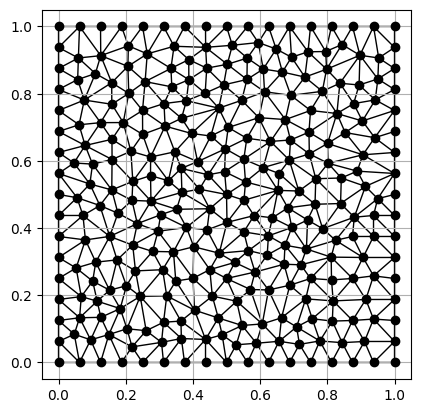

In [14]:
gedim.PlotMesh(mesh)

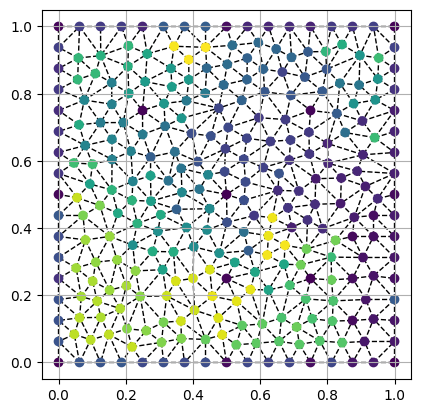

In [15]:
gedim.PlotDofs(mesh, dofs, strongs)

In [16]:
# Initialization of the guess of the solution --> the NM converges rapidly if we start not far away from the solution
u_k = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong = np.zeros(problemData['NumberStrongs'], order='F') # Vector containing the strongly imposed components of the solution, ie Dirichlet conditions

#### Newton method for high fidelity snapshots computation

In [17]:
####### ASSEMBLE ONCE OFFLINE AND ONLY NECESSARY STUFF AT EVERT ITERATION
# RELATIVO A G_1
sample_mu_0 = np.random.uniform(0.1, 1, 100) # Uniform sampling in mu_Rang of 100 samples
sample_mu_1 = np.random.uniform(0.1, 1, 100)

snapshots_matrix = []
convergence_history = []  
max_iterations = 100
newton_tol = 1e-8
sol_quad_hf = []

# OFFLINE PHASE: ASSEMBLING STUFF NON PARAMETER DEPENDANT
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) # linear part 

for mu_0, mu_1 in zip(sample_mu_0, sample_mu_1):
    
    # Set Newton parameter at each change of the parameter
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    num_iteration = 1
    rel_error = 0
    # u_k = np.zeros(problemData['NumberDOFs'], order='F') #riaggiorna u_k iniziale

    # Iterative step - Setting a relative tollerance
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm:
        

        # ONLINE PHASE : ASSEMBLE STUFF PARAMETER DEPENDANT
        # 1- Left side of the equation
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Non linear 
        # 2- Right hand side of the function
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Non linear part
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # TO BE ASSEMBLED ONLINE FOR G2!!!
        # Solving with the LU solver because we're in a generic setting (no idea of the structure of the matrix)
        lhs = stiffness + reaction
        rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        
        u_k = u_k + du # Update
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        du_norms_for_sample.append(du_norm)
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

    
        # Compute the relative error of two consecutive iterations
        rel_error = du_norm / u_k_norm       
        
        num_iteration = num_iteration + 1

    snapshots_matrix.append(np.copy(u_k))
    convergence_history.append(du_norms_for_sample)

    # Compute the sol on the quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on qudrature points
    sol_quad_hf.append(solution_hf)

    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_err_L2':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")

snapshots_matrix = np.array(snapshots_matrix)
print(f"snapshots_matrix.shape: {snapshots_matrix.shape}")

last_u_k_exact = u_k

mu_0       mu_1       iters  rel_err_L2    
0.5656     0.6791     8      9.97e-10      
mu_0       mu_1       iters  rel_err_L2    
0.9523     0.6115     8      3.66e-09      
mu_0       mu_1       iters  rel_err_L2    
0.7889     0.3162     8      8.17e-09      
mu_0       mu_1       iters  rel_err_L2    
0.3542     0.3661     8      2.34e-09      
mu_0       mu_1       iters  rel_err_L2    
0.2989     0.1045     8      5.49e-09      
mu_0       mu_1       iters  rel_err_L2    
0.7176     0.2160     9      8.57e-09      
mu_0       mu_1       iters  rel_err_L2    
0.2504     0.5762     8      6.06e-09      
mu_0       mu_1       iters  rel_err_L2    
0.4532     0.6827     7      6.37e-10      
mu_0       mu_1       iters  rel_err_L2    
0.6562     0.2308     8      5.56e-09      
mu_0       mu_1       iters  rel_err_L2    
0.4707     0.7223     7      2.41e-09      
mu_0       mu_1       iters  rel_err_L2    
0.1022     0.6450     8      1.46e-09      
mu_0       mu_1       iters  rel

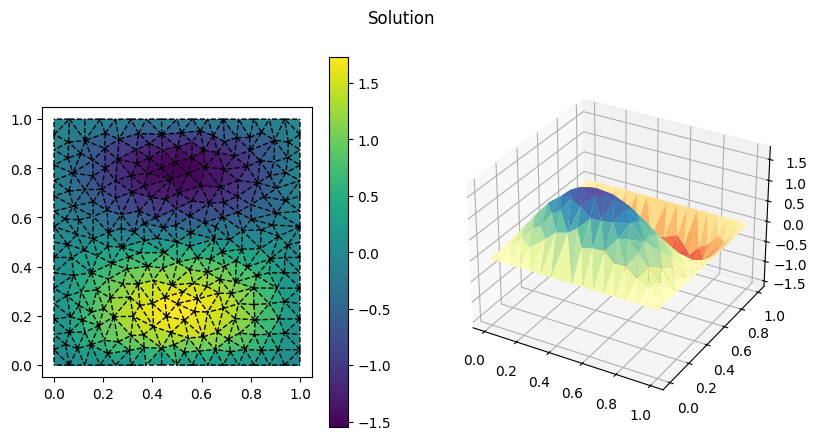

quadratureWeights: [0.00059755 0.00059755 0.00059755 ... 0.00064649 0.00064649 0.00064649]


In [18]:
# Plot and show the solution
gedim.PlotSolution(mesh, dofs, strongs, last_u_k_exact, u_strong)
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(last_u_k_exact, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, last_u_k_exact, lib)
print(f"quadratureWeights: {quadratureWeights}")

gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) # To export solutions on paraview

# 2. POD

#### Compute the covariance matrix of snapshots

In [19]:
# We assemble here the covariance matrix and inner prod matrix
#[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
inner_product = stiffness 

# Definitio of the covariance matrix
C = snapshots_matrix @ inner_product @ np.transpose(snapshots_matrix) 

#### Find the reduced dimension N using eigenvalues explained variance

In [20]:
# Eigenvalue problem
tol = 1. - 1e-7

L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.) # We need a symmetic positive definite matrix: all eigenvalues real and positive
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues) # Sum of all the eigenvalues
retained_energy_vector = np.cumsum(eigenvalues) # Cumulative sum (summing until n)
relative_retained_energy = retained_energy_vector/total_energy # "Percentage"

# We want the first term for that the relative_retained_energy is less then 1 - 1e-7
if all(flag==False for flag in relative_retained_energy>= tol): 
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1 # Python works from 0, but the basis goes from 1

# I need 3 basis (see the resutl) to show everything, this means that with 3 
# eigenvalues we reach the condition, and all the other are very very small (irrelevant)
print("The reduced dimension is N =", N) 

The reduced dimension is N = 9


#### Plot of the cumulative explained variance

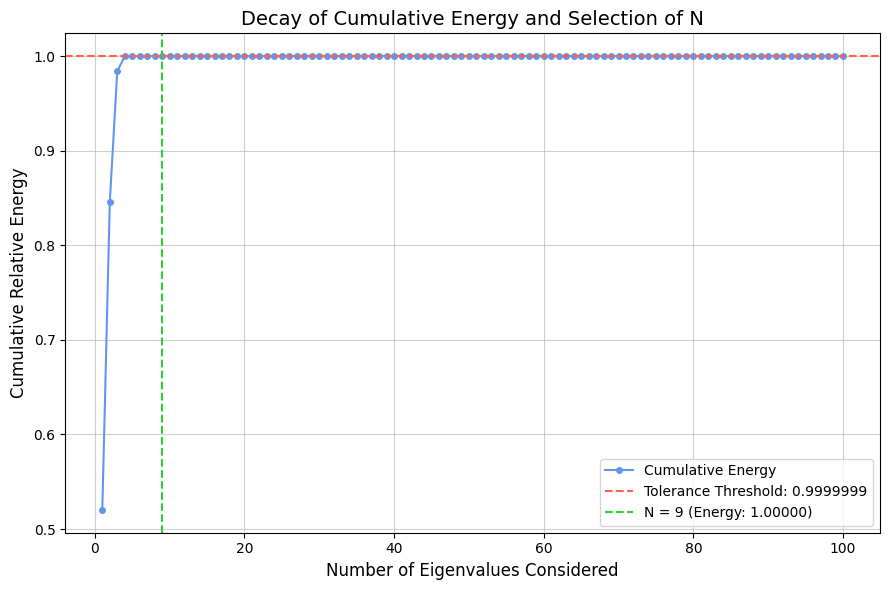

In [21]:
plt.figure(figsize=(9, 6)) # Slightly larger figure for better readability
# Plot the cumulative energy
# Using a slightly darker pastel blue and smaller marker for a cleaner look
plt.plot(range(1, len(relative_retained_energy) + 1), relative_retained_energy,
         marker='o', markersize=4, linestyle='-', color='#6495ED', # CornflowerBlue
         label='Cumulative Energy')

# Horizontal line for the tolerance threshold
plt.axhline(y=tol, color='#FF6347', linestyle='--', linewidth=1.5, # Tomato
            label=f'Tolerance Threshold: {tol:.7f}')

# Vertical line for N
# Get the value of cumulative energy at N
if 1 <= N <= len(relative_retained_energy):
    energy_at_N = relative_retained_energy[N - 1]
    # Format the energy value to be readable (e.g., 5 decimal places or scientific notation if very small)
    formatted_energy_at_N = f'{energy_at_N:.5f}' if energy_at_N > 0.001 else f'{energy_at_N:.2e}'
    plt.axvline(x=N, color='#32CD32', linestyle='--', linewidth=1.5, # LimeGreen
                label=f'N = {N} (Energy: {formatted_energy_at_N})') # Added formatted energy value to label
else:
    plt.axvline(x=N, color='#32CD32', linestyle='--', linewidth=1.5, # LimeGreen
                label=f'N = {N}') # Fallback if N is out of bounds

# Customize labels and title with slightly larger fonts for better visibility
plt.xlabel('Number of Eigenvalues Considered', fontsize=12)
plt.ylabel('Cumulative Relative Energy', fontsize=12)
plt.title('Decay of Cumulative Energy and Selection of N', fontsize=14)

# Add grid lines for better readability
plt.grid(True, which="both", ls="-", alpha=0.6) # Solid grid lines, slightly transparent

plt.legend(loc='lower right', fontsize=10) # Position legend for better fit
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

#### Basis function for the reduced dimensional space

In [22]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  basis = np.transpose(snapshots_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) # ||u||_H^1 = u'Xu 
  
  basis /= norm # Normalizing
  basis_functions.append(np.copy(basis)) # Have all together all the basis

basis_functions = np.transpose(np.array(basis_functions))
print("basis shape:", basis_functions.shape)

basis shape: (214, 9)


### Define the functions to compute errors


In [23]:
########### ERROR FUNCTION TO COMPUTE ERROR BETWEEN FOM AND PROJECTED ROM RESULTS #########
# Compute the error for the solution
def compute_error(fom_solution, rom_solution_FE_basis, inner_product=None, type_err="relative"):
    
    error_function_u = fom_solution - rom_solution_FE_basis
    
    if inner_product == None:
      inner_product_matrix = np.identity(fom_solution.shape[0])
    else:
      inner_product_matrix = inner_product
    
    error_norm_squared_component = np.transpose(error_function_u) @ inner_product_matrix @ error_function_u
    absolute_error = np.sqrt(abs(error_norm_squared_component))
    
    if type_err == "absolute":
      return absolute_error
    
    else:
      full_solution_norm_squared_component = np.transpose(fom_solution) @  inner_product_matrix @ fom_solution
      relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    
      return relative_error

In [24]:
################## ERROR FUNCTION TO COMPUTE ERROR ON QUADRATURE POINTS##############
def compute_L2_H1_errors_separated(hf_u_set, hf_ux_set, hf_uy_set,
                                   pinn_u_set, pinn_ux_set, pinn_uy_set, weights=None,
                                   zero_tol=1e-14):
    l2_abs_errors = []
    l2_rel_errors = []
    h1_abs_errors = []
    h1_rel_errors = []

    for u_HF, ux_HF, uy_HF, u_pinn, ux_pinn, uy_pinn in zip(
        hf_u_set, hf_ux_set, hf_uy_set, pinn_u_set, pinn_ux_set, pinn_uy_set
    ):
        diff_u = u_pinn - u_HF
        diff_ux = ux_pinn - ux_HF
        diff_uy = uy_pinn - uy_HF

        if weights is not None:
            l2_abs = np.sqrt(np.sum(weights * diff_u**2))
            norm_u_HF = np.sqrt(np.sum(weights * u_HF**2))
            l2_rel = l2_abs / norm_u_HF if norm_u_HF > zero_tol else np.nan

            h1_abs = np.sqrt(np.sum(weights * (diff_u**2 + diff_ux**2 + diff_uy**2)))
            norm_HF_H1 = np.sqrt(np.sum(weights * (u_HF**2 + ux_HF**2 + uy_HF**2)))
            h1_rel = h1_abs / norm_HF_H1 if norm_HF_H1 > zero_tol else np.nan

        else:
            N_q = len(diff_u)
            l2_abs = np.linalg.norm(diff_u) / np.sqrt(N_q)
            norm_u_HF = np.linalg.norm(u_HF) / np.sqrt(N_q)
            l2_rel = l2_abs / norm_u_HF if norm_u_HF > zero_tol else np.nan

            h1_abs = np.sqrt(
                np.linalg.norm(diff_u)**2 +
                np.linalg.norm(diff_ux)**2 +
                np.linalg.norm(diff_uy)**2
            ) / np.sqrt(N_q)

            norm_HF_H1 = np.sqrt(
                np.linalg.norm(u_HF)**2 +
                np.linalg.norm(ux_HF)**2 +
                np.linalg.norm(uy_HF)**2
            ) / np.sqrt(N_q)
            h1_rel = h1_abs / norm_HF_H1 if norm_HF_H1 > zero_tol else np.nan

        l2_abs_errors.append(l2_abs)
        l2_rel_errors.append(l2_rel)
        h1_abs_errors.append(h1_abs)
        h1_rel_errors.append(h1_rel)

    print(f"L2 absolute error (mean): {np.nanmean(l2_abs_errors):.4e}")
    print(f"L2 relative error (mean): {np.nanmean(l2_rel_errors):.4e}")
    print(f"H1 absolute error (mean): {np.nanmean(h1_abs_errors):.4e}")
    print(f"H1 relative error (mean): {np.nanmean(h1_rel_errors):.4e}")

    return {
        "L2 Absolute": np.nanmean(l2_abs_errors),
        "L2 Relative": np.nanmean(l2_rel_errors),
        "H1 Absolute": np.nanmean(h1_abs_errors),
        "H1 Relative": np.nanmean(h1_rel_errors)
    }


### Evaluation of the POD 

#### a) comparison of POD and high fidelity results for ONE value of mu 
(will be useful to plot and export the solutions, even if it's less explicative than the mean error) 

In [25]:
# ASSEMBLE OFFLINE STUFF (NON PARAMETER DEPENDANT)
# Reduce operator
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
reduced_stiff = np.transpose(basis_functions) @ stiffness @ basis_functions

### OFFLINE STOP

In [26]:
# pick a test parameter randomly ---> we'll use this couple of parameters to test also PODNN for one value of mu
test_mu_0 = np.random.uniform(0.1, 1, 1)
test_mu_1 = np.random.uniform(0.1, 1, 1)

In [27]:
### ONLINE START
# 1) FIX MU_0, MU_1
mu_0 =  test_mu_0
mu_1 =  test_mu_1

#### Solve the problem using Newton in the reduced space of dimension 3
at every step of the newton algorithm assemble the online terms and project them in the reduced space, solve for du and update u_k in the reduced space (find reduced_du and update reduced_u_k), then project them in the fom space and evaluate the error, until convergence

In [28]:
# Set Newton parameter at each change of the parameter
du_norm = 1.0
u_k_norm = 1.0
num_iteration = 1
du_norms_for_sample = []
num_iteration = 1
rel_error = 0
max_iterations = 100
newton_tol = 1e-8
# u_k = np.zeros(problemData['NumberDOFs'], order='F') #riaggiorna u_k iniziale
reduced_u_k = np.zeros(N)

while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm:
    # Assemble reaction online
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Sì PARAMETRI
    reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # Projection
    
    # Assemble non linear derivative forcing term online
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib) 
    reduced_forcingTerm_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v 
    # Assemble forcing term online
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Sì PARAMETRI
    reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v 
    # Assemble the forcing term 
    forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # TO BE ASSEMBLED ONLINE FOR G2!!!
    reduced_forcingTerm_g =  np.transpose(basis_functions) @ forcingTerm_g
    
    reduced_lhs = reduced_stiff + reduced_react
    reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v
    reduced_du = np.linalg.solve(reduced_lhs, reduced_rhs)
    
    reduced_u_k = reduced_u_k + reduced_du # Update

    du = basis_functions @ reduced_du 
    u_k = basis_functions @ reduced_u_k 
    # Compute norm for stopping criterium
    du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
    u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm
    # Compute the relative error of two consecutive iterations
    rel_error = du_norm / u_k_norm       
    
    num_iteration = num_iteration + 1
    
# Compute the sol on the quadrature points
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol_pod_mu_test, sol_x_pod_mu_test, sol_y_pod_mu_test] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)

# Print at the end of the iteration before the change of the parameter
print(f"mu_0 : {mu_0}, mu_1 : {mu_1}, iters: {num_iteration -1}, rel_error : {rel_error}")
#print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")

proj_sol_pod_mu_test = u_k

mu_0 : [0.16103737], mu_1 : [0.74922409], iters: 8, rel_error : 8.026715871786112e-09


#### Plot the reduced solution projected in the fom space

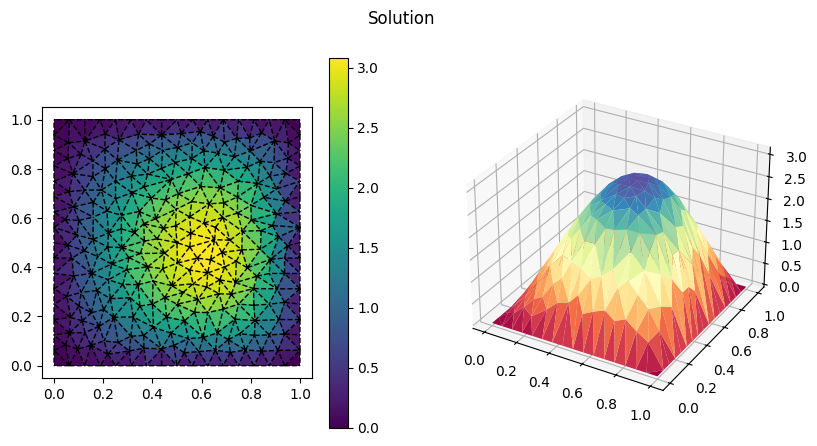

In [29]:
# plot the reduce solution projected
gedim.PlotSolution(mesh, dofs, strongs, proj_sol_pod_mu_test, u_strong) 
#gedim.ExportSolution(Elliptic_exactSolution, u_k, u_strong, lib) CAPIRE COME E SE ESPORTARLA

#### Compute the full solution with same mu to plot it (for comparison)
again apply newton method to solve the problem for mu but this time everything is done at fom level, so in higher dimension (more accurate but more computationally expensive and time demanding, how much? we'll see in the speed up part, for now let's compare the errors)

mu_0 : [0.16103737], mu_1 : [0.74922409], iters: 4, rel_error : 4.384638153140427e-09


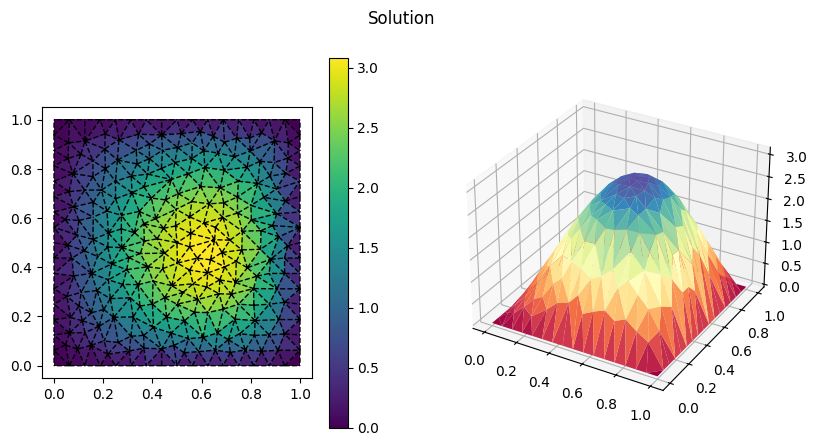

In [30]:
# Set Newton parameter at each change of the parameter
du_norm = 1.0
u_k_norm = 1.0
num_iteration = 1
du_norms_for_sample = []
num_iteration = 1
rel_error = 0
max_iterations = 100
newton_tol = 1e-8
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) 
# Iterative step - Setting a relative tollerance
while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

    # 1- Left side of the equation
    # Non linear 
    [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
    
    # 2- Right hand side of the function
    # Non linear part
    forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
    forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # TO BE ASSEMBLED ONLINE FOR G2!!!
    
    lhs = stiffness + reaction
    rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
    du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
    
    u_k = u_k + du # Update
    
    # Compute norm for stopping criterium
    du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
    du_norms_for_sample.append(du_norm)
    u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm
    
    
    # Compute the relative error of two consecutive iterations
    rel_error = du_norm / u_k_norm       
    
    num_iteration = num_iteration + 1
    
    # Compute the sol on the quadrature points
    [numQuadraturePoints, quadraturePoints, quadratureWeights, sol_hf_mu_test, sol_x_hf_mu_test, sol_y_hf_mu_test] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)

print(f"mu_0 : {mu_0}, mu_1 : {mu_1}, iters: {num_iteration -1}, rel_error : {rel_error}")
solution_hf_mu_test = u_k
gedim.PlotSolution(mesh, dofs, strongs, solution_hf_mu_test, u_strong)

In [31]:
###### errors for mu test
# 1) fom-rom with pod relative and absolute error
abs_err_pod_mu_test = compute_error(solution_hf_mu_test, proj_sol_pod_mu_test, inner_product=inner_product, type_err="absolute")
rel_err_pod_mu_test = compute_error(solution_hf_mu_test, proj_sol_pod_mu_test, inner_product=inner_product)

print(" relative error fom-rom with pod on mu test= ", np.mean(rel_err_pod_mu_test) )
print(" absolute error fom-rom with pod on mu test= ", np.mean(abs_err_pod_mu_test) )

# 2) fom-rom with pod error on quadrature points
errors_quadrature_pod_mu_test = compute_L2_H1_errors_separated(sol_hf_mu_test, sol_x_hf_mu_test, sol_y_hf_mu_test,
                                   sol_pod_mu_test, sol_x_pod_mu_test, sol_y_pod_mu_test, weights=quadratureWeights)

 relative error fom-rom with pod on mu test=  0.0007489275860589737
 absolute error fom-rom with pod on mu test=  0.005765934585484188
L2 absolute error (mean): 2.8663e-04
L2 relative error (mean): 2.9440e-04
H1 absolute error (mean): 4.9485e-03
H1 relative error (mean): 7.8850e-04


#### b) comparison of POD and high fidelity results for a test set of values of mu
will be useful to compare the average results and the computational time in the rom and fom cases and to compute speed up

Define a test set of parameters that we'll use to compute the high dielity and pod solutions, so that we'll be able to compare them

In [32]:
testing_set = np.random.uniform(low=0.1, high=1, size=(100, 2))

#### Compute solutions with Newton in the ROM space 

In [33]:
print("Computing solutions in ROM space and projecting using the POD basis for every test mu")
# to save computational times for every mu
time_rom_list = []
# to save errors for every mu
abs_err_pod = []
rel_err_pod = []
# save rom solutions projected in fom space for every mu
projected_rom_sol = []
# to save stuff for quadrature error computation 
pod_u_set = []
pod_ux_set = []
pod_uy_set = []

# offline assemble
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib)
reduced_stiff = np.transpose(basis_functions) @ stiffness @ basis_functions

for mu in testing_set:
    # take the couple of parameters
    mu_0 = mu[0]
    mu_1 = mu[1]

    #initialize loop stuff
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    num_iteration = 1
    u_k = np.zeros(problemData['NumberDOFs'], order='F') #riaggiorna u_k iniziale


    # initialize execution time to solve rom for every mu
    time_rom = 0
    # initialize errors for every mu
    rel_error = 0
    abs_error = 0
    # DOMANDA : NON HA PIù SENSO USARE LO STOPPING CRITERION NEL ROM SPACE??? reduced_du_norm > newton_tol * reduced_u_k_norm e solo alla fine riproiettare???
    # usual stopping criterion evaluated on the projected du and u_k (from rom to fom)
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 
        # Assemble reaction online
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib) # Sì PARAMETRI
        reduced_react = np.transpose(basis_functions) @ reaction @ basis_functions # Projection
        
        # Assemble non linear derivative forcing term online
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib) 
        reduced_forcingTerm_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v 
        # Assemble forcing terms online
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib) # Sì PARAMETRI
        reduced_forcingTerm_v =  np.transpose(basis_functions) @ forcingTerm_v 
        
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib) # TO BE ASSEMBLED ONLINE FOR G2!!!
        reduced_forcingTerm_g =  np.transpose(basis_functions) @ forcingTerm_g
        
        reduced_lhs = reduced_stiff + reduced_react
        reduced_rhs = reduced_forcingTerm_g - reduced_forcingTerm_v - reduced_forcingTerm_der_v
        
        start_rom = time.time()
        reduced_du = np.linalg.solve(reduced_lhs, reduced_rhs) # solve for du in rom
        time_rom += time.time() - start_rom
        
        reduced_u_k = reduced_u_k + reduced_du # update u_k in rom
    
        du = basis_functions @ reduced_du
        u_k = basis_functions @ reduced_u_k 
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm
        
        # Compute the relative error of two consecutive iterations
        rel_error = du_norm / u_k_norm  
        abs_error = du_norm
        
        num_iteration = num_iteration + 1

    # Compute the sol on the quadrature points #CHECK THIS THING
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_pod, solution_x_pod, solution_y_pod] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on quadrature points
    pod_u_set.append(solution_pod)
    # append solution derivative wrt x on quadraure points
    pod_ux_set.append(solution_x_pod)
    # append solution derivative wrt y on quadraure points
    pod_uy_set.append(solution_y_pod)
    
    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_error':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")
    # for every mu save : 
    projected_rom_sol.append(u_k)
    # computational time
    time_rom_list.append(time_rom)
    # error 
    rel_err_pod.append(rel_error)
    abs_err_pod.append(abs_error)

Computing solutions in ROM space and projecting using the POD basis for every test mu
mu_0       mu_1       iters  rel_error     
0.2094     0.8286     8      1.01e-09      
mu_0       mu_1       iters  rel_error     
0.9413     0.4082     9      2.67e-09      
mu_0       mu_1       iters  rel_error     
0.3814     0.6403     7      1.26e-09      
mu_0       mu_1       iters  rel_error     
0.7251     0.1407     9      8.21e-09      
mu_0       mu_1       iters  rel_error     
0.6641     0.2579     10     7.31e-09      
mu_0       mu_1       iters  rel_error     
0.1729     0.3823     9      1.41e-09      
mu_0       mu_1       iters  rel_error     
0.4727     0.4553     8      2.21e-09      
mu_0       mu_1       iters  rel_error     
0.7507     0.5605     9      9.99e-09      
mu_0       mu_1       iters  rel_error     
0.4093     0.5220     7      7.00e-09      
mu_0       mu_1       iters  rel_error     
0.5921     0.8514     8      8.49e-09      
mu_0       mu_1       iters  rel_e

In [34]:
####### AVERAGE RELATIVE AND ABSOLUTE ERROR OF POD : RESIDUAL ERROR ##########
print("average relative residual error rom = ", np.mean(rel_err_pod) )
print("average absolute residual error rom = ", np.mean(abs_err_pod) )

average relative residual error rom =  3.1335091255785214e-09
average absolute residual error rom =  3.500148702134942e-09


#### Compute solutions with Newton in the FOM space

In [35]:
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Elliptic_a, problemData, lib) 

print("Computing solutions in FOM space for every test mu")
# to save computational times for every mu
time_fom_list = []
# to save errors for every mu
abs_err_hf = []
rel_err_hf = []
# save fom solutions for every mu
fom_sol = []
# to save stuff for quadrature error computation 
hf_u_set = []
hf_ux_set = []
hf_uy_set = []



for mu in testing_set:
    
    # take the couple of parameters
    mu_0 = mu[0]
    mu_1 = mu[1]

    #initialize loop stuff
    du_norm = 1.0
    u_k_norm = 1.0
    num_iteration = 1
    du_norms_for_sample = []
    num_iteration = 1
    u_k = np.zeros(problemData['NumberDOFs'], order='F') #riaggiorna u_k iniziale

    # initialize execution time to solve rom for every mu
    time_fom = 0
    # initialize errors for every mu
    rel_error = 0
    abs_error = 0 # usual stopping criterion evaluated on the projected du and u_k (from rom to fom)
    while num_iteration < max_iterations and du_norm > newton_tol * u_k_norm: 

        # 1- Left side of the equation
        # Non linear 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Elliptic_c, Elliptic_non_linear_c, u_k, u_strong, problemData, lib)
        # 2- Right hand side of the function
        # Non linear part
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Elliptic_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Elliptic_non_linear_der_f, u_k, u_strong, problemData, lib)
        forcingTerm_g = gedim.AssembleForcingTerm(Elliptic_g_1, problemData, lib)  # TO BE ASSEMBLED ONLINE FOR G2!!!
        
        lhs = stiffness + reaction
        rhs = forcingTerm_g - forcingTerm_v - forcingTerm_der_v
        
        start_fom = time.time() 
        du = gedim.LUSolver(lhs,\
                            rhs, \
                            lib)
        time_fom += time.time() - start_fom
        
        u_k = u_k + du # update u_k
        
        # Compute norm for stopping criterium
        du_norm = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)  # ||du|| = ||u(k) - u(k-1)|| L^2-norm
        du_norms_for_sample.append(du_norm)
        u_k_norm = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # ||u_k|| L^2-norm

        
        # Compute the relative error of two consecutive iterations
        rel_error = du_norm / u_k_norm  
        abs_error = du_norm     
        
        num_iteration = num_iteration + 1

    # Compute the sol on the quadrature points #CHECK THIS THING
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_hf, solution_x_hf, solution_y_hf] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
    # append solution on quadrature points
    hf_u_set.append(solution_hf)
    # append solution derivative wrt x on quadraure points
    hf_ux_set.append(solution_x_hf)
    # append solution derivative wrt y on quadraure points
    hf_uy_set.append(solution_y_hf)

    # Print at the end of the iteration before the change of the parameter
    print(f"{'mu_0':<10} {'mu_1':<10} {'iters':<6} {'rel_error':<14}")
    print(f"{mu_0:<10.4f} {mu_1:<10.4f} {(num_iteration-1):<6d} {rel_error:<14.2e}")
        
    # for every mu save : 
    fom_sol.append(u_k)
    # computational time
    time_fom_list.append(time_fom)
    # error 
    rel_err_hf.append(rel_error)
    abs_err_hf.append(abs_error)

Computing solutions in FOM space for every test mu
mu_0       mu_1       iters  rel_error     
0.2094     0.8286     7      5.89e-10      
mu_0       mu_1       iters  rel_error     
0.9413     0.4082     7      9.03e-09      
mu_0       mu_1       iters  rel_error     
0.3814     0.6403     6      5.74e-09      
mu_0       mu_1       iters  rel_error     
0.7251     0.1407     9      2.15e-09      
mu_0       mu_1       iters  rel_error     
0.6641     0.2579     9      1.40e-09      
mu_0       mu_1       iters  rel_error     
0.1729     0.3823     8      6.20e-09      
mu_0       mu_1       iters  rel_error     
0.4727     0.4553     6      2.27e-09      
mu_0       mu_1       iters  rel_error     
0.7507     0.5605     8      6.77e-09      
mu_0       mu_1       iters  rel_error     
0.4093     0.5220     6      9.44e-09      
mu_0       mu_1       iters  rel_error     
0.5921     0.8514     8      1.69e-09      
mu_0       mu_1       iters  rel_error     
0.4133     0.8049     6  

In [36]:
####### AVERAGE RELATIVE AND ABSOLUTE ERROR OF HIGH FIDELITY SOLUTIONS : RESIDUAL ERROR ##########
print("average relative residual error high fidelity : ", np.mean(rel_err_hf) )
print("average absolute residual error high fidelity solutions : ", np.mean(abs_err_hf) )

average relative residual error high fidelity :  3.4907039088466552e-09
average absolute residual error high fidelity solutions :  3.734282123473927e-09


#### Error between high fidelity solutions and rom solutions (obtained with POD) projected to fom space

In [37]:
############# ERROR FOM-ROM COMPUTATION #############
abs_err = []
rel_err = []
for i in range(0, len(testing_set)):
    absolute = compute_error(fom_sol[i], projected_rom_sol[i], inner_product=inner_product, type_err="absolute")
    relative = compute_error(fom_sol[i], projected_rom_sol[i], inner_product=inner_product)
    abs_err.append(absolute)
    rel_err.append(relative)

In [38]:
print("average relative error rom-fom = ", np.mean(rel_err) )
print("average absolute error rom-fom = ", np.mean(abs_err) )

print("average time fom: ", np.mean(time_fom_list))
print("average time rom: ", np.mean(time_rom_list))
speed_ups = np.array(time_fom_list) / np.array(time_rom_list)
print("average speed_up = ", np.mean(speed_ups) )

average relative error rom-fom =  0.0009966323955853487
average absolute error rom-fom =  0.006199633222087131
average time fom:  0.013283021450042724
average time rom:  0.0008031725883483887
average speed_up =  16.949137397615065


In [39]:
########## ERROR ON QUADRATURE POINTS COMPUTATION ############
errors_quadrature = compute_L2_H1_errors_separated(hf_u_set, hf_ux_set, hf_uy_set,
                                   pod_u_set, pod_ux_set, pod_uy_set, weights=quadratureWeights)

L2 absolute error (mean): 4.9361e-04
L2 relative error (mean): 5.1432e-04
H1 absolute error (mean): 6.2197e-03
H1 relative error (mean): 9.8641e-04


# 3. POD-NN 

In [40]:
import torch
import torch.nn as nn
from torch.autograd import Variable


In [41]:
# define the net and its dimensions
mu_dim = 2 
basis_dim = N #N=9 --> found doing POD
input_dim = mu_dim # net takes mu=(mu_0,mu_1) as input
output_dim = basis_dim # net outputs a reduced solution uN of dim N=3
nodes = 40

#let us use this net for now, then we'll see
class Net(nn.Module):
    def __init__(self):
         super(Net, self).__init__()
         # Starting layer
         self.fc1 = nn.Linear(input_dim, nodes)
        
         # Hidden layer
         self.fc2 = nn.Linear(nodes, nodes)
         self.fc3 = nn.Linear(nodes, nodes)
         self.fc4 = nn.Linear(nodes, nodes)
         # Finish hidden layer
         # Last layer
         self.fc5 = nn.Linear(nodes, output_dim)
        
         self.tanh = nn.Tanh()
     # self.apply(self._init_weights)
    def forward(self, x): ### Forward law ----> prediction
         # Activation function
         x = self.tanh(self.fc1(x)) # Iperbolic tangent [-1, 1]
         x = self.tanh(self.fc2(x))
         x = self.tanh(self.fc3(x))
         x = self.tanh(self.fc4(x))
        
         x = self.fc5(x) # This is the output, we do not change the range of the solution
         # It is better to leave the final solution in the space where it is to do not modify it
        
         return x

### Training step

In [42]:
#set seed
seed_num = 23 # You can change this, different seed == different initialization of weight --> maybe better performance
torch.manual_seed(seed_num)

# call model, loss and optimizer (to be changed maybe)
model = Net()
torch.set_default_dtype(torch.float32)
my_loss = nn.MSELoss() # MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define the training parameters
epoch_max = 500000
epoch = 0
tol = 1e-6
loss = 1. # To start the optimization

In [43]:
## training set definition 

# Reshape to column vectors
sample_mu_0 = sample_mu_0.reshape(-1, 1)  # shape: (200, 1)
sample_mu_1 = sample_mu_1.reshape(-1, 1)  # shape: (200, 1)

# Now concatenate column-wise
training_set = np.hstack((sample_mu_0, sample_mu_1)) # ha senso trainare sugli stessi mu con cui ho costruito newton? non conviene risamplarli??

In [44]:
print(training_set.shape)

(100, 2)


In [45]:
# NB: x (= input of model) = mu , y (=output of model) = uN
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
mu_train = torch.tensor(np.float32(training_set)) # The input are all the parameters that I have
uN_train = []
for i in range(snapshots_matrix.shape[0]):
    snapshot_to_project = snapshots_matrix[i]
    # We have to solve X_N u_rb = B^T X_delta u_delta
    projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
    uN_train.append(projected_snapshot) # On dimension N=3
uN_train = np.float32(uN_train)
uN_train = torch.tensor(uN_train) # To np object to tensor
print(uN_train.shape)

torch.Size([100, 9])


In [46]:
##### TRAINING LOOP #######
while loss >= tol and epoch < epoch_max:
    epoch = epoch + 1
    optimizer.zero_grad()
    
    ## compute output
    uN_pred = model(mu_train) # Net apply to my parameter --> to each parameter I have a solution in dimension 9 that are the projection
    
    loss = my_loss(uN_pred, uN_train) # Computing the loss
    
    if epoch >= 100000:
        optimizer.param_groups[0]['lr'] = 0.0001 # To change the learning rate during the epoch with a dictionary
    
    #compute the gradients
    loss.backward()
    
    # optimizer update
    optimizer.step()
    
    if epoch % 1000 == 199:
        print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

print("tot number of epochs trained:", epoch)

epoch 199 loss 41.110504150390625 lr 0.001
epoch 1199 loss 35.15610122680664 lr 0.001
epoch 2199 loss 11.906346321105957 lr 0.001
epoch 3199 loss 5.023334503173828 lr 0.001
epoch 4199 loss 2.5386507511138916 lr 0.001
epoch 5199 loss 0.708042323589325 lr 0.001
epoch 6199 loss 0.2746376097202301 lr 0.001
epoch 7199 loss 0.11810436099767685 lr 0.001
epoch 8199 loss 0.0723847970366478 lr 0.001
epoch 9199 loss 0.041746899485588074 lr 0.001
epoch 10199 loss 0.029290691018104553 lr 0.001
epoch 11199 loss 0.01636820286512375 lr 0.001
epoch 12199 loss 0.0092158867046237 lr 0.001
epoch 13199 loss 0.006148989778012037 lr 0.001
epoch 14199 loss 0.004917411599308252 lr 0.001
epoch 15199 loss 0.004292031284421682 lr 0.001
epoch 16199 loss 0.008754784241318703 lr 0.001
epoch 17199 loss 0.00471601402387023 lr 0.001
epoch 18199 loss 0.002093633869662881 lr 0.001
epoch 19199 loss 0.018679821863770485 lr 0.001
epoch 20199 loss 0.0015181381022557616 lr 0.001
epoch 21199 loss 0.0013890293193981051 lr 0.001

### Error evaluation of PODNN 

#### a) comparison of PODNN and high fidelity results for ONE value of mu 

In [47]:
# take the previously used mu test
mu_0 = test_mu_0
mu_1 = test_mu_1
mu_test = np.array((mu_0, mu_1)).reshape(1,-1)
mu_test = np.float32(mu_test)
print(mu_test.shape)

(1, 2)


In [48]:
########### COMPUTATION OF ROM SOLUTION WITH PODNN ###############
# Compute reduced solution using the trained model
mu_test = torch.tensor(mu_test)
reduced_solution = np.asarray(model(mu_test).detach().numpy())[0] 
print(reduced_solution) # In dimension 3

[ -2.2092214  10.645775    5.373876    4.7813387   6.4695625   3.2331996
  -2.9663444  21.183784  -17.248608 ]


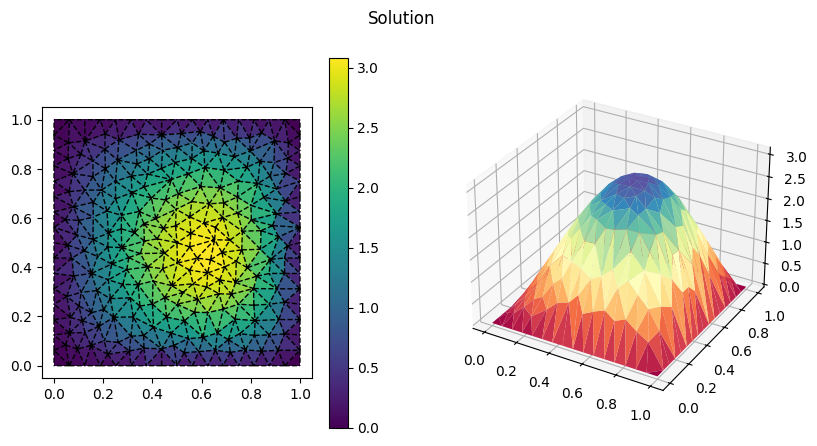

In [49]:
# Project the solution to fom space to see it 
proj_sol_podnn_mu_test = basis_functions @ reduced_solution
# Compute the sol on the quadrature points #CHECK THIS THING
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol_podnn_mu_test, sol_x_podnn_mu_test, sol_y_podnn_mu_test] = gedim.EvaluateSolutionOnPoints(proj_sol_podnn_mu_test, u_strong, lib)
# plot solution
gedim.PlotSolution(mesh, dofs, strongs, proj_sol_podnn_mu_test, np.zeros(problemData['NumberStrongs']))

In [50]:
###### errors for mu test
# 1) fom-rom with podnn relative and absolute error
abs_err_pod_mu_test = compute_error(solution_hf_mu_test, proj_sol_podnn_mu_test, inner_product=inner_product, type_err="absolute")
rel_err_pod_mu_test = compute_error(solution_hf_mu_test, proj_sol_podnn_mu_test, inner_product=inner_product)

print("relative error fom-rom with pod on mu test= ", np.mean(rel_err_pod_mu_test) )
print("absolute error fom-rom with pod on mu test= ", np.mean(abs_err_pod_mu_test) )

# 2) fom-rom with podnn error on quadrature points
errors_quadrature_pod_mu_test = compute_L2_H1_errors_separated(sol_hf_mu_test, sol_x_hf_mu_test, sol_y_hf_mu_test,
                                   sol_podnn_mu_test, sol_x_podnn_mu_test, sol_y_podnn_mu_test, weights=quadratureWeights)

relative error fom-rom with pod on mu test=  0.0008914366713805184
absolute error fom-rom with pod on mu test=  0.0068631008257146655
L2 absolute error (mean): 4.2048e-04
L2 relative error (mean): 4.1091e-04
H1 absolute error (mean): 5.6248e-03
H1 relative error (mean): 8.7197e-04


#### b) comparison of POD and high fidelity results for a test set of values of mu
will be useful to compare the average results and the computational time in the rom and fom cases and to compute speed up

In [51]:
# to save computational times for every mu
times_podnn_list = []
# save rom solutions projected in fom space for every mu 
projected_podnn_sol = []
# to save stuff for quadrature error computation 
podnn_u_set = []
podnn_ux_set = []
podnn_uy_set = []

print("Computing solution in ROM space using PODNN net and projecting it to FOM space for every test mu") 

for i, mu in enumerate(testing_set):
    mu_0 = mu[0]
    mu_1 = mu[1]
    #print(f"iteration: {i}, mu_0 : {mu_0}, mu_1: {mu_1} ")

    #### POD-NN #####
    mu_test = np.array((mu_0, mu_1)).reshape(1,-1)
    mu_test = np.float32(mu_test)
    mu_test = torch.tensor(mu_test)
    
    start_rom = time.time()
    reduced_solution = np.asarray(model(mu_test).detach().numpy())[0]
    time_rom = time.time() - start_rom
    
    proj_reduced_solution = basis_functions @ reduced_solution
    projected_podnn_sol.append(proj_reduced_solution)

    # saving times
    times_podnn_list.append(time_rom)
    # Compute the sol on the quadrature points 
    [numQuadraturePoints, quadraturePoints, quadratureWeights, solution_podnn, solution_x_podnn, solution_y_podnn] = gedim.EvaluateSolutionOnPoints(proj_reduced_solution, u_strong, lib)
    # append solution on quadrature points
    podnn_u_set.append(solution_podnn)
    # append solution derivative wrt x on quadraure points
    podnn_ux_set.append(solution_x_podnn)
    # append solution derivative wrt y on quadraure points
    podnn_uy_set.append(solution_y_podnn)

Computing solution in ROM space using PODNN net and projecting it to FOM space for every test mu


#### Error between high fidelity solutions and rom solutions (obtained with PODNN) projected to fom space

In [52]:
################ ERROR FOM-ROM WITH PODNN COMPUTATION ##########
abs_err = []
rel_err = []
for i in range(0, len(testing_set)):
    absolute = compute_error(fom_sol[i], projected_podnn_sol[i], inner_product=inner_product, type_err="absolute")
    relative = compute_error(fom_sol[i], projected_podnn_sol[i], inner_product=inner_product)
    abs_err.append(absolute)
    rel_err.append(relative)

In [53]:
print("average relative error podnn-fom = ", np.mean(rel_err) )
print("average absolute error podnn-fom = ", np.mean(abs_err) )

print("average time fom: ", np.mean(time_fom_list))
print("average time rom: ", np.mean(times_podnn_list))
speed_ups = np.array(time_fom_list) / np.array(times_podnn_list)
print("average speed_up = ", np.mean(speed_ups) )

average relative error podnn-fom =  0.02855991674106755
average absolute error podnn-fom =  0.1706040478319719
average time fom:  0.013283021450042724
average time rom:  0.0001922130584716797
average speed_up =  82.76936021403462


In [54]:
########## ERROR ON QUADRATURE POINTS COMPUTATION ############
errors_quadrature = compute_L2_H1_errors_separated(hf_u_set, hf_ux_set, hf_uy_set,
                                   podnn_u_set, podnn_ux_set, podnn_uy_set, weights=quadratureWeights)

L2 absolute error (mean): 3.0481e-02
L2 relative error (mean): 3.1003e-02
H1 absolute error (mean): 1.7342e-01
H1 relative error (mean): 2.8608e-02
